In [1]:
%%capture
!pip install plotly
!pip install nltk
!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Visualisierungen
- Mean Sentiment over time per party
- Sentiment per MP
-  Männliche vs. weibliche Politiker vergleich
- Minority vergleich (überhaupt möglich?)
- Hate unter Politikern
- Wordclouds

In [4]:
df = pd.read_csv("mentions_predicted_exploded.csv")
#df = df.drop(['Unnamed: 0'], axis=1)
df.head()
len(df)

2752124

In [5]:
df.party[0]

' Die Linke'

In [6]:
#df = df[df["party"] != " fraktionslos "]
df.drop(df.loc[df["party"]==" fraktionslos"].index, inplace=True)

In [7]:
df.party.value_counts()

 SPD                      1016954
 Bündnis 90/Die Grünen     705546
 FDP                       429378
 CDU/CSU                   300284
 AfD                       157906
 Die Linke                 140582
Name: party, dtype: int64

In [8]:
#df = df.sample(10000)
df.head(5)

,Unnamed: 0.2,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,...,replies,likes,mentioned,Runs,model_predictions,mentioned_list,full_name,party,Geschlecht,Gewählt in Vorperiode
0,0,0,0,1,1.435941e+18,CHARLYCAPRI4,1,14.0,NaN,NaN,...,0.0,0.0,['SWagenknecht'],Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja
1,1,1,1,2,5.286774e+08,jo711,6,308.0,"Ewiger Revolluzer :-) ,\nBiker,Hundeverrückt.N...",jo,...,0.0,0.0,['SWagenknecht'],Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja
2,2,2,2,3,7.622651e+08,nimmdenbus,1574,118892.0,Take the bus! Prenez le bus! Mein Herz schlägt...,NaN,...,0.0,0.0,"['MarvinWendland1', 'SWagenknecht', 'BinBerlin...",Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja
3,3,5,5,6,1.357859e+18,MeisterKlar,0,487.0,Nichts! ich bin einmalig wie jeder andere auch!,NaN,...,0.0,0.0,['SWagenknecht'],Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja
4,4,6,6,9,7.622651e+08,nimmdenbus,1574,118892.0,Take the bus! Prenez le bus! Mein Herz schlägt...,NaN,...,0.0,1.0,"['SWagenknecht', 'BinBerlinerIn']",Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja


# Data Analysis

In [9]:
# because on mention row was found in the created_at column
df = df[~df['created_at'].astype(str).str.startswith('[')]
df = df[~df['created_at'].astype(str).str.startswith('S')]
df = df[~df['created_at'].astype(str).str.startswith('F')]
df = df[~df['created_at'].astype(str).str.startswith('C')]
df = df[~df['created_at'].astype(str).str.startswith('A')]
df = df[~df['created_at'].astype(str).str.startswith('D')]
df = df[~df['created_at'].astype(str).str.startswith('B')]

In [10]:
df["created_at"][0]

'2022-03-31 23:51:42+00:00'

In [11]:
df["created_at"] = df["created_at"].astype('datetime64[ns]') 
df["created_at"] = df.created_at.dt.to_pydatetime()

In [12]:
len(df)

2750650

In [13]:
# Date Spalte erstellen
df["Date"]  = df["created_at"]
#df['Date']= pd.to_datetime(df['Date'])

df["HOF"] = df["model_predictions"]
df.loc[(df.model_predictions == 1),'Label']='HOF'
df.loc[(df.model_predictions == 0),'Label']='NOT'

In [14]:
df.head(2)

,Unnamed: 0.2,Unnamed: 0.1,index,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,...,Runs,model_predictions,mentioned_list,full_name,party,Geschlecht,Gewählt in Vorperiode,Date,HOF,Label
0,0,0,0,1,1.435941e+18,CHARLYCAPRI4,1,14.0,NaN,NaN,...,Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja,2022-03-31 23:51:42,0,NOT
1,1,1,1,2,5.286774e+08,jo711,6,308.0,"Ewiger Revolluzer :-) ,\nBiker,Hundeverrückt.N...",jo,...,Linke_polis_1,0,swagenknecht,Dr. Sahra Wagenknecht,Die Linke,Frau,ja,2022-03-31 23:51:27,0,NOT


In [15]:
df.party.value_counts()

 SPD                      1016954
 Bündnis 90/Die Grünen     705546
 FDP                       429378
 CDU/CSU                   300284
 AfD                       157906
 Die Linke                 140582
Name: party, dtype: int64

In [16]:
df["party"] = df["party"].replace(" SPD", "SPD")
df["party"] = df["party"].replace(" Bündnis 90/Die Grünen", "Bündnis 90/Die Grünen")
df["party"] = df["party"].replace(" FDP", "FDP")
df["party"] = df["party"].replace(" CDU/CSU", "CSU/CDU")
df["party"] = df["party"].replace(" AfD", "AfD")
df["party"] = df["party"].replace(" Die Linke", "Die Linke")

In [17]:
afd = df[df["party"] == "AfD"]
cducsu = df[df["party"] == "CSU/CDU"]
linke = df[df["party"] == "Die Linke"]
fdp = df[df["party"] == "FDP"]
gruene = df[df["party"] == "Bündnis 90/Die Grünen"]
spd = df[df["party"] == "SPD"]

In [18]:
# group by party and look at sentiment distribution per party
afd_pos = afd[afd["model_predictions"] == 0].username.count()
afd_neg = afd[afd["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
spd_pos = spd[spd["model_predictions"] == 0].username.count()
spd_neg = spd[spd["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
linke_pos = linke[linke["model_predictions"] == 0].username.count()
linke_neg = linke[linke["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
fdp_pos = fdp[fdp["model_predictions"] == 0].username.count()
fdp_neg = fdp[fdp["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
gruene_pos = gruene[gruene["model_predictions"] == 0].username.count()
gruene_neg = gruene[gruene["model_predictions"] == 1].username.count()

# group by party and look at sentiment distribution per party
cducsu_pos = cducsu[cducsu["model_predictions"] == 0].username.count()
cducsu_neg = cducsu[cducsu["model_predictions"] == 1].username.count()

pos = df[df["model_predictions"] == 0].username.count()
neg = df[df["model_predictions"] == 1].username.count()

## Plots over Time

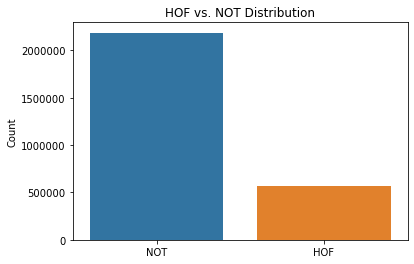

In [19]:
ax = sns.barplot(x=["NOT", "HOF"], y=[pos,neg])
ax.set_title('HOF vs. NOT Distribution')
ax.set_ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')

In [55]:
ax.figure.savefig("./plots/exploded_hof_distribution.png")

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



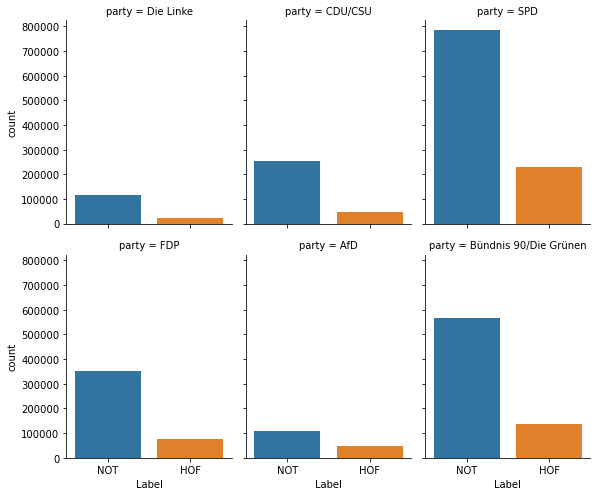

In [56]:
# Plot
g = sns.catplot("Label", col="party", col_wrap=3,
                data=df,
                kind="count", height=3.5, aspect=.8, 
                palette='tab10')

#fig.suptitle('sf')
plt.show()
g.savefig('./plots/exploded_party_hof_distribution.png')

In [25]:
day = []
for index, row in df.iterrows():
    date = row["Date"].date()
    day.append(date)
    
df["day"] = day
df["Partei"] = df["party"]
day_sentiment_df = df.pivot_table(index=['Partei', 'day'], values='model_predictions', aggfunc='mean').reset_index()
day_sentiment_df

,Partei,day,model_predictions
0,AfD,2022-02-01,0.319160
1,AfD,2022-02-02,0.278167
2,AfD,2022-02-03,0.295175
3,AfD,2022-02-04,0.301688
4,AfD,2022-02-05,0.332326
...,...,...,...
349,SPD,2022-03-27,0.223882
350,SPD,2022-03-28,0.221267
351,SPD,2022-03-29,0.263085
352,SPD,2022-03-30,0.229005


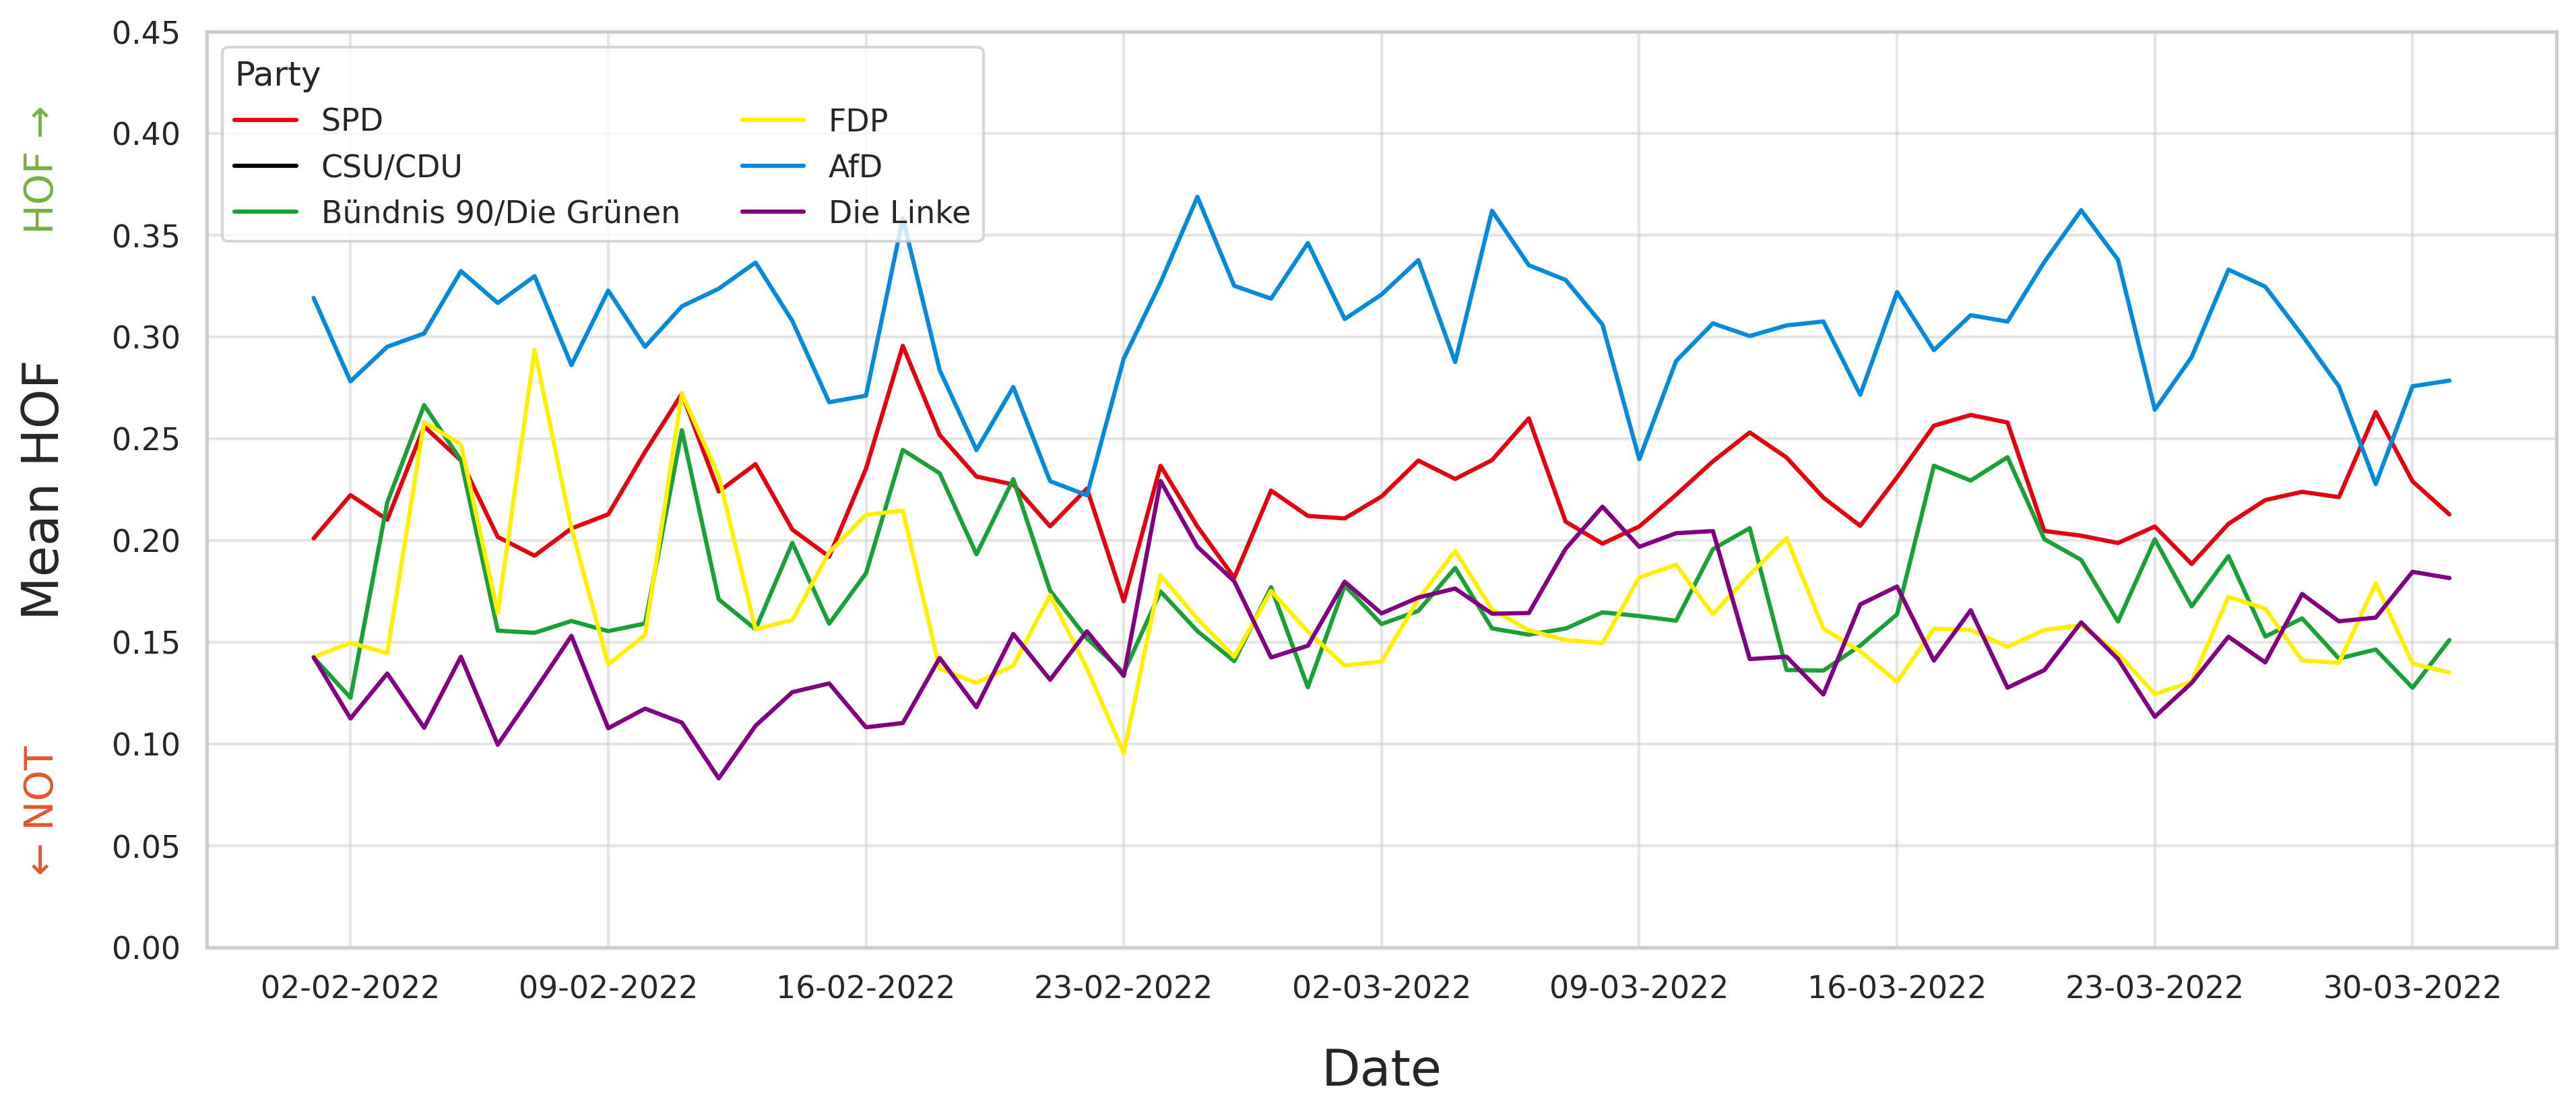

In [58]:
from time_plots import plot_line_graph_for_each_day, plot_reg_line_graph_for_each_day, plot_percentage

plot_line_graph_for_each_day(day_sentiment_df, "./plots/exploded_hof_party_over_time")

In [23]:
def f_2021(row):
    if row['party'] == "AfD":
        val = "Opposition"
    elif row['party'] == "Die Linke":
        val = "Opposition"
    elif row['party'] == "CSU/CDU":
        val = "Opposition"
    elif row['party'] == "Bündnis 90/Die Grünen":
        val = "Government"
    elif row['party'] == "FDP":
        val = "Government"
    elif row['party'] == "SPD":
        val = "Government"
    else:
        val = "NA"
    return val

In [24]:
#df['Regierungsstatus_2017'] = df.apply(f_2017, axis=1)
df['Regierungsstatus_2021'] = df.apply(f_2021, axis=1)

In [26]:
#df['day'] = (i.date for in in df["Date"])
reg_day_sentiment_df = df.pivot_table(index=['Regierungsstatus_2021', 'day'], values='model_predictions', aggfunc='mean').reset_index()
reg_day_sentiment_df

,Regierungsstatus_2021,day,model_predictions
0,Government,2022-02-01,0.177110
1,Government,2022-02-02,0.187800
2,Government,2022-02-03,0.204562
3,Government,2022-02-04,0.260258
4,Government,2022-02-05,0.241409
...,...,...,...
113,Opposition,2022-03-27,0.191317
114,Opposition,2022-03-28,0.194990
115,Opposition,2022-03-29,0.196156
116,Opposition,2022-03-30,0.188549


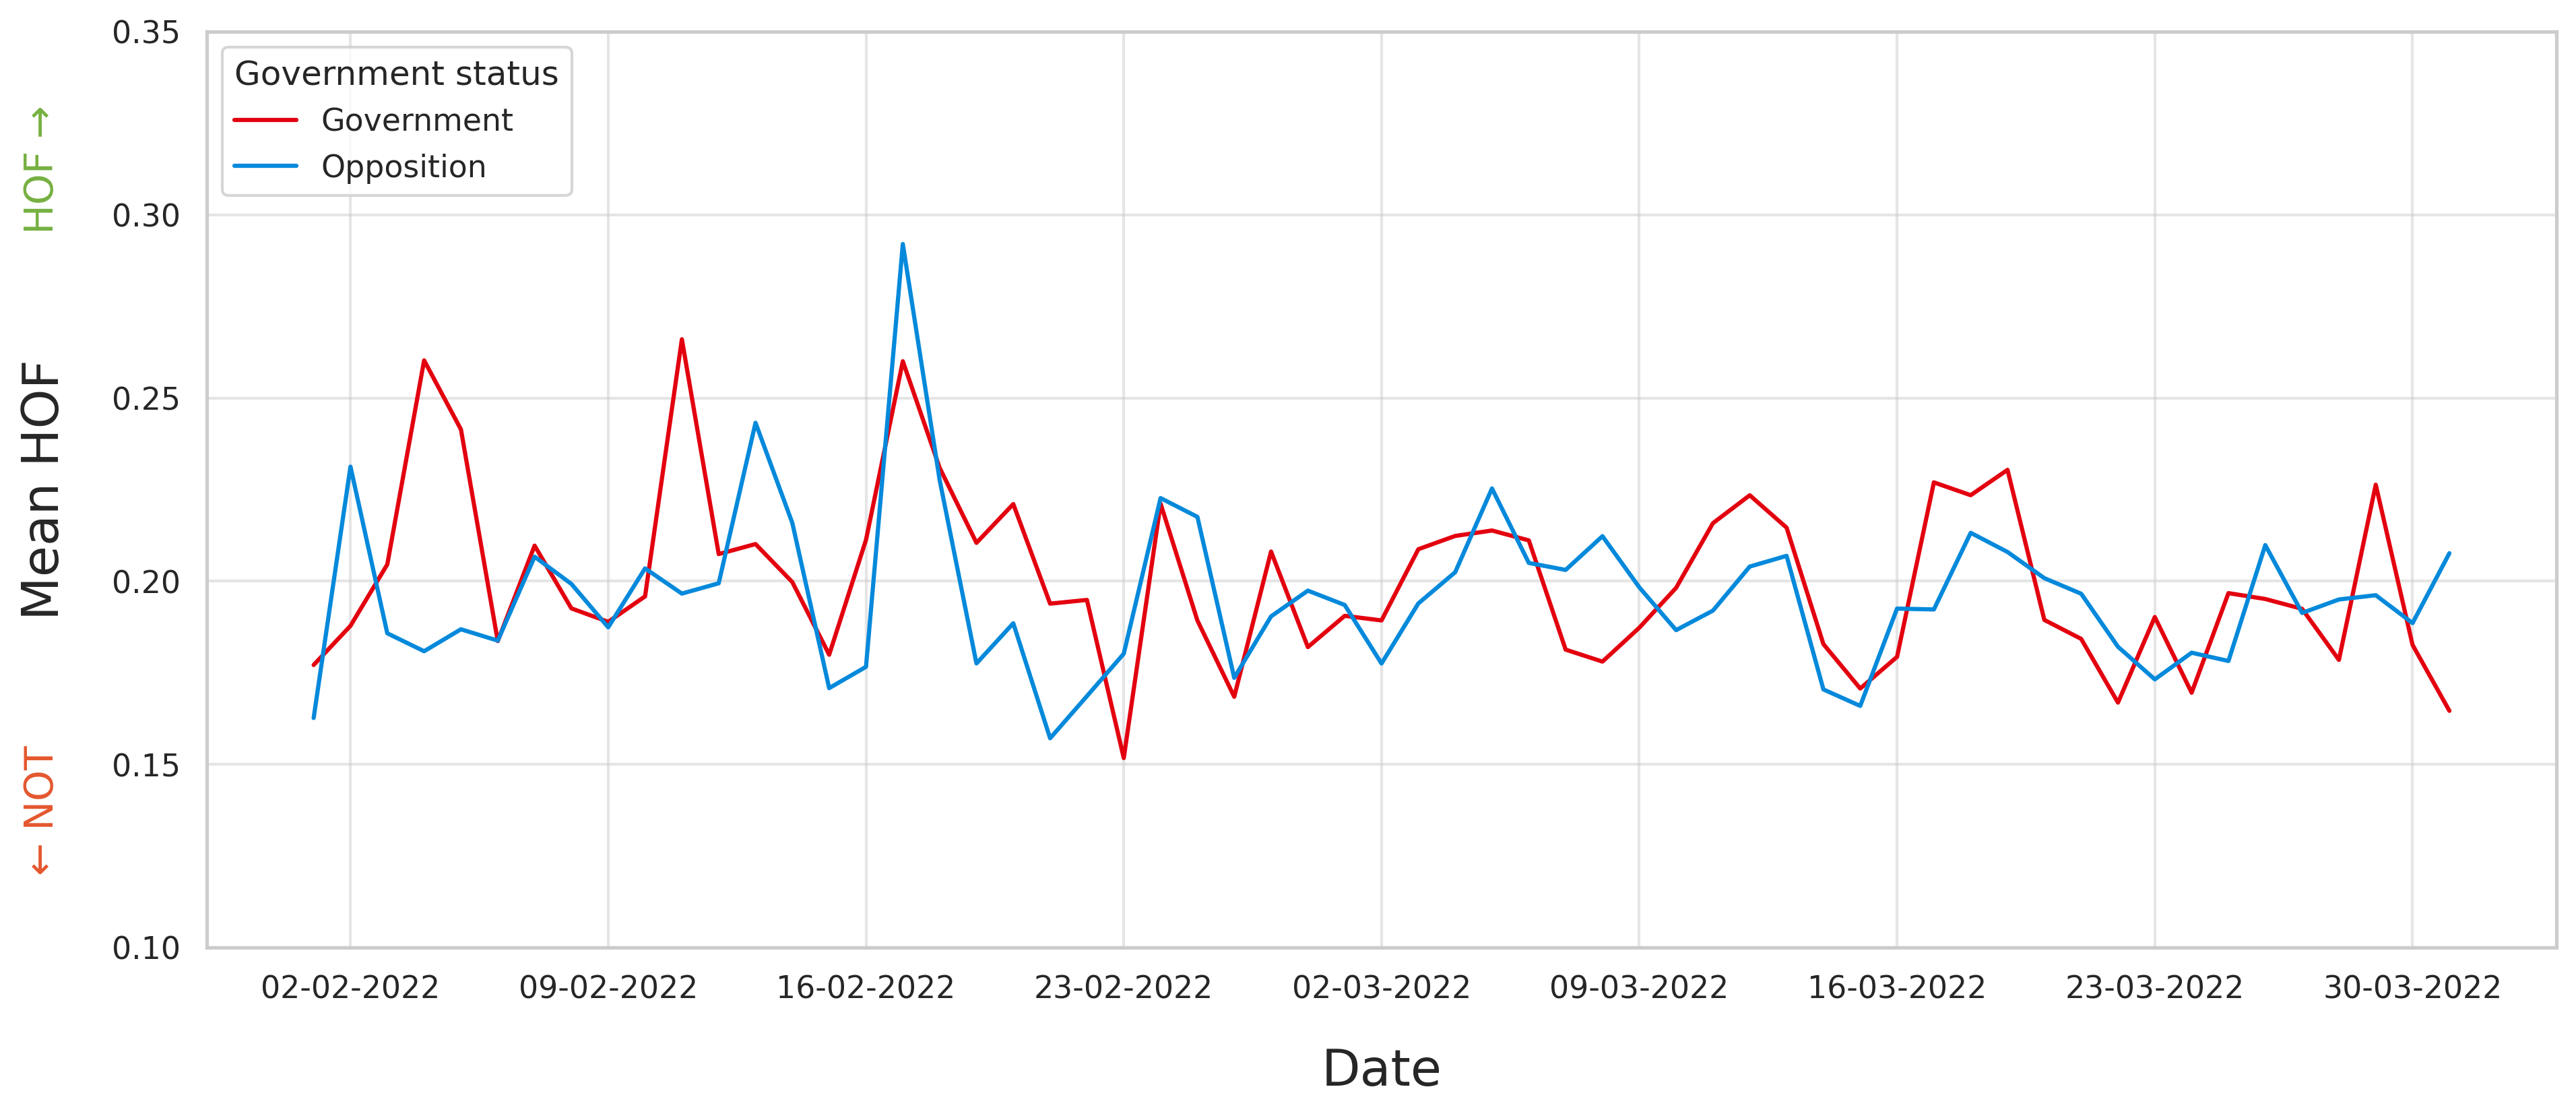

In [27]:
from time_plots import plot_reg_line_graph_for_each_day
plot_reg_line_graph_for_each_day(reg_day_sentiment_df, "./plots/exploded_hof_regierung_over_time")

## Plot Percentage Distribution

In [28]:
df["Partei"].value_counts()

SPD                      1016954
Bündnis 90/Die Grünen     705546
FDP                       429378
CSU/CDU                   300284
AfD                       157906
Die Linke                 140582
Name: Partei, dtype: int64

In [29]:
data = df.groupby(["Partei"])["model_predictions"].value_counts().unstack()
data

model_predictions,0,1
Partei,,
AfD,109823,48083
Bündnis 90/Die Grünen,568358,137188
CSU/CDU,252820,47464
Die Linke,118311,22271
FDP,352076,77302
SPD,785051,231903


In [30]:
df["Partei"] = df["Partei"].replace("CDU/CSU", "CSU/CDU")

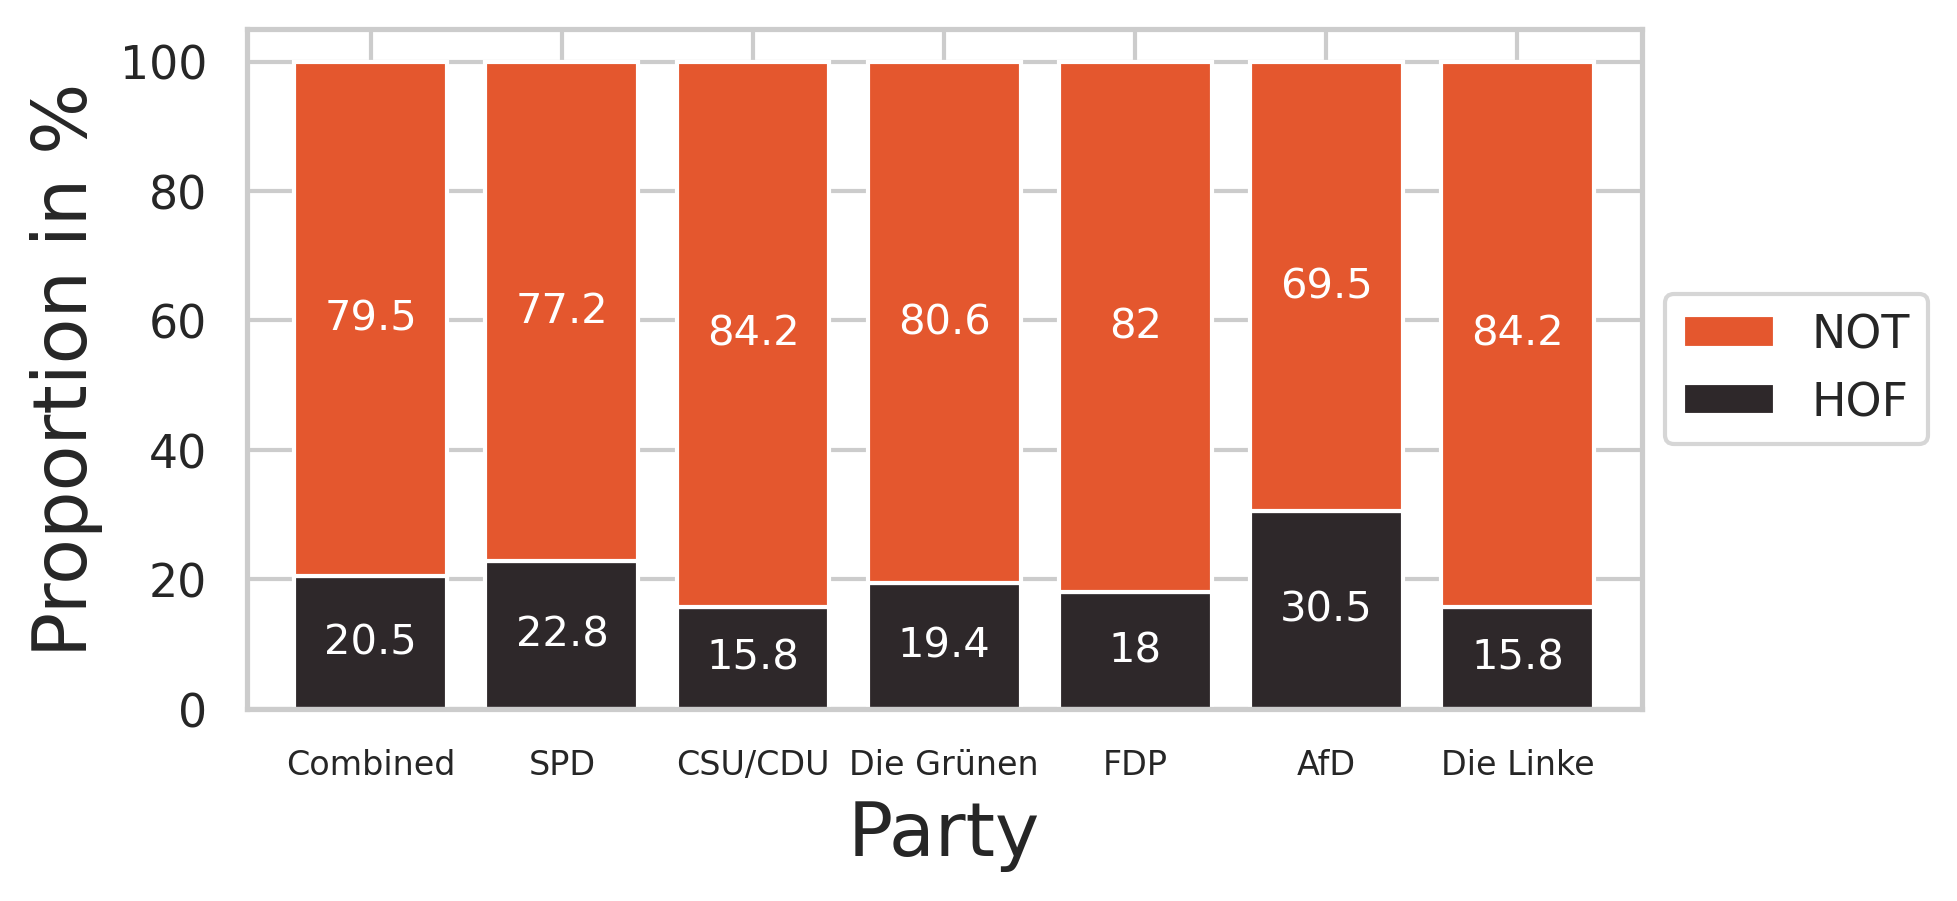

In [32]:
from time_plots import plot_percentage
plot_percentage(df, "plots/exploded_percentage_distribution")